OSCILADOR ARMÓNICO AMORTIGUADO FORZADO: Diagramas de Poincaré, dimensión fractal y distribución de tiempos

In [69]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy as scipy
from math import *
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


VALORES NUMÉRICOS DEL PROBLEMA

Condiciones iniciales

In [70]:
x_0 = 1 # Posición inicial
v_0 = 0 # Velocidad inicial

Parámetros del sistema

In [71]:
w_0 = 0.5 # Frecuencia natural x>0
W_0 = 100 # Frecuencia natural x<0
amort = 0.125 # Constante de amortiguamiento
f_0 = 0.25 # Amplitud de la fuerza por unidad de masa

Medida del tiempo

In [72]:
dt = 0.001 # Paso de tiempo
tf = 2000 # Tiempo de medida (se asume que t0 = 0)
t = np.linspace(0,tf,int(tf/dt)+1) # Vector de instantes de tiempo

Frencuencia angular de la fuerza externa

In [73]:
dw = 0.001 # paso en la frecuencia externa
w =  np.array([i*dw for i in range(int(12*0.1/dw),int(1.6/dw)+1)]) # Frecuencia fuerza externa

DEFINIMOS UNA FRECUENCIA NATURAL DEL OSCILADOR QUE DEPENDE DE LA POSICIÓN

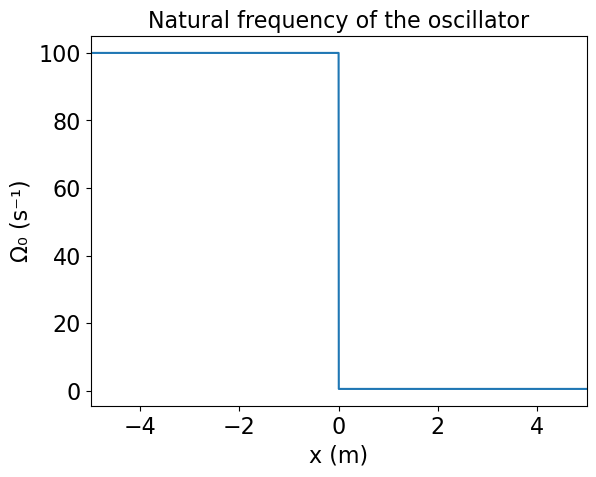

In [74]:
def W(x): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
rep = np.linspace(-5,5,5000)
plt.plot(rep,W(rep)) # Representación gráfica de la frecuencia natural
plt.title('Natural frequency of the oscillator',fontsize = 16)
plt.xlabel('x (m)',fontsize = 16)
plt.ylabel('Ω₀ (s⁻¹)',fontsize = 16)
plt.xlim([min(rep),max(rep)])
#plt.savefig('Frecuencia natural.png')
plt.show()

POTENCIAL DEL OSCILADOR

In [75]:
def W2(x,W_0,w_0): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

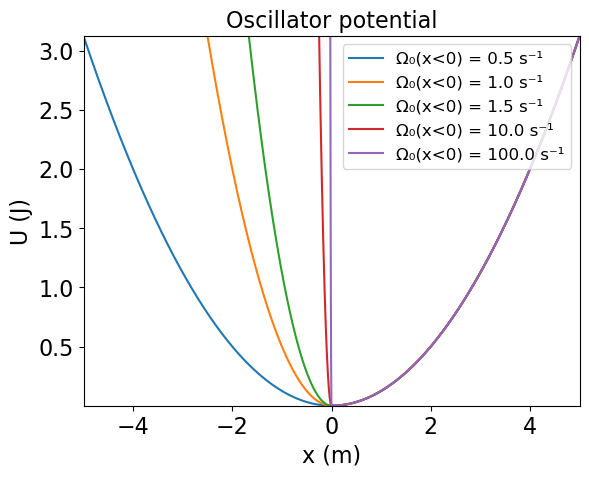

In [76]:
rep = np.linspace(-5,5,5000)
U = (1/2)*W2(rep,w_0,w_0)**2*rep**2
U2 = (1/2)*W2(rep,w_0+0.5,w_0)**2*rep**2
U3 = (1/2)*W2(rep,w_0+1,w_0)**2*rep**2
U4 = (1/2)*W2(rep,w_0+9.5,w_0)**2*rep**2
U5 = (1/2)*W2(rep,w_0+99.5,w_0)**2*rep**2

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.plot(rep,U,label = 'Ω₀(x<0) = '+str(format(w_0,'.1f'))+' s⁻¹')
plt.plot(rep,U2,label = 'Ω₀(x<0) = '+str(format(w_0+0.5,'.1f'))+' s⁻¹')
plt.plot(rep,U3,label = 'Ω₀(x<0) = '+str(format(w_0+1,'.1f'))+' s⁻¹')
plt.plot(rep,U4,label = 'Ω₀(x<0) = '+str(format(w_0+9.5,'.1f'))+' s⁻¹')
plt.plot(rep,U5,label = 'Ω₀(x<0) = '+str(format(w_0+99.5,'.1f'))+' s⁻¹')

plt.title('Oscillator potential',fontsize = 16)
plt.xlabel('x (m)',fontsize = 16)
plt.ylabel('U (J)',fontsize = 16)
plt.xlim([min(rep),max(rep)])
plt.ylim([min(U),(1/2)*W2(max(rep),w_0,w_0)**2*max(rep)**2])
plt.legend(loc = 'upper right',fontsize = 12)
#plt.savefig('Figura potencial del oscilador.png')
plt.show()

ECUACIÓN DIFERENCIAL

In [77]:
def EDO(t,y,w):
    x,v = y
    return [v,-2*amort*v-W(x)**2*x+f_0*np.cos(w*t)]

CÁLCULO DE LOS INTERVALOS DE TIEMPO ENTRE CHOQUES SUCESIVOS

In [78]:
def time_intervals(x):
    v = x.copy()
    bin = v[1:(t.size-1)]
    bin[[v[i]*v[i-1]>0 for i in range(1,t.size-1)]] = 0
    bin[bin<0] = -1
    bin[bin>0] = 1
    v[v.size-1] = -1

    tindpos = np.where(v > 0)[0]
    tindneg = np.where(v < 0)[0]

    if np.size(tindpos) > np.size(tindneg):
        tindpos = np.delete(tindpos,int(np.size(tindpos))-1)
    if np.size(tindpos) < np.size(tindneg):
        tindneg = np.delete(tindneg,int(np.size(tindneg))-1)

    return (tindneg-tindpos)[1:(len(tindneg-tindpos)-1)]*dt

CÁLCULO DEL MOVIMIENTO DEL SISTEMA

Integración de la EDO

In [79]:
pos = []
vel = []
xp = []
vp = []
tdist = []

for i in tqdm(range(np.size(w))):
    sol = scipy.integrate.solve_ivp(EDO, [0,tf], [x_0,v_0], method = 'RK23',t_eval = t,args = [w[i]])
    x,v = sol.y
    pos.append(x)
    vel.append(v)

    T = 2*pi/w[i] # Periodo fuerza externa
    n = int(tf/T) # Número de puntos del diagrama de Poincaré
    ind = np.array([np.searchsorted(t,T*(i+1)) for i in range(n-1)]) # Calculamos los índices del diagrama de Poincaré
    xp.append(x[ind]) # Asignamos índices encontrados en tiempos con posiciones y velocidades (/max(x[ind]))
    vp.append(v[ind])

    tdist.append(time_intervals(x)) # Calculamos los intervalos de tiempo entre choques


100%|██████████| 401/401 [6:35:10<00:00, 59.13s/it]      


DIMENSIÓN FRACTAL

Método de Box Counting

In [82]:
def FractalDimension(xp,vp,w): # Función que calcula la dimensión fractal de una imagen
    fig = plt.figure()
    plt.plot(xp[50:],vp[50:],'.',color='red',markersize='1')
    plt.axis('off')
    plt.xlim([min(xp)-0.1,max(xp)])
    plt.ylim([min(vp)-0.1,max(vp)])
    plt.savefig('Poincaré ω = '+str(format(w,'.3f'))+'.png', transparent=True)
    plt.close(fig)
    image = plt.imread('Poincaré ω = '+str(format(w,'.3f'))+'.png')[:,:,3]
    
    Lx = image.shape[0]
    Ly = image.shape[1]
    pixels=[]
    Ns=[]
    E = np.logspace(0, 2, num = 100, endpoint=False, base=2)
    #E = [0.01,0.1,0.5,1,2,4,8,16,32]

    for i in range(Lx):
        for j in range(Ly):
            if image[i,j] > 0:
                pixels.append((i,j))

    pixels=np.array(pixels)
    
    for eps in E:
        Box, ejes = np.histogramdd(pixels, bins=(np.arange(0,Lx,eps),np.arange(0,Ly,eps)))
        Ns.append(np.sum(Box>0))
    fig2 = plt.figure()
    plt.plot(np.log(E),np.log(Ns),'.')
    plt.close(fig2)
    sol = np.polyfit(np.log(E),np.log(Ns),1,full=True)
    dF = -sol[0][0]
    r = sol[1]
    
    if r > 0.2:
        return nan,nan
    else:
        return dF,r

Cálculo de la dimensión fractal

In [83]:
df = np.zeros(np.size(w))
res = np.zeros(np.size(w))

for i in tqdm(range(np.size(w))):
    df[i],res[i] = FractalDimension(xp[i],vp[i],w[i])

100%|██████████| 401/401 [06:21<00:00,  1.05it/s]


EVOLUCIÓN DEL DIAGRAMA DE POINCARÉ CON W

Actualización del diagrama en cada frame de la animación

In [84]:
def update_Poincare(num,xp,vp):
    plt.cla()
    plt.plot(xp[num][50:],vp[num][50:],'.',color='red',markersize='1')
    plt.xlim([-0.05,0.4])
    plt.ylim([-0.25,0.4])
    plt.title('Evolución del diagrama de Poincaré con ω')
    plt.xlabel('x (m)')
    plt.ylabel('v (m/s)')
    plt.suptitle('ω = '+str(format(w[num],'.3f'))+' s⁻¹')

Representación de resultados mediante animación

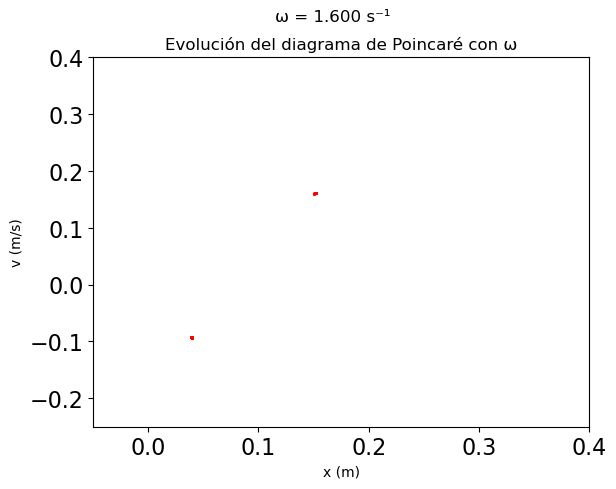

In [85]:
im = plt.figure()
fig = plt.plot(xp[0][50:],vp[0][50:],'.',color='red',markersize='1')
plt.xlim([-0.05,0.4])
plt.ylim([-0.25,0.4])
plt.title('Evolución del diagrama de Poincaré con ω')
plt.xlabel('x (m)')
plt.ylabel('v (m/s)')
plt.suptitle('ω = '+str(format(w[0],'.3f'))+' s⁻¹')

animP = animation.FuncAnimation(im, update_Poincare, np.size(w), fargs = (xp,vp, ), interval = 100)
animP.save('Evolución Poincaré ω.gif')
animP.save('Evolución Poincaré ω.mp4')

DIAGRAMA DE POINCARÉ SEGÚN EL INSTANTE DE TIEMPO EN EL QUE SE REGISTREN LOS PUNTOS (INDEPENDIENTE DEL RESTO DEL CÓDIGO)

Solución del movimiento para una frecuencia en el régimen caótico

In [86]:
wT = 1.411
tfT = 50000
tT = np.linspace(0,tfT,int(tfT/dt)+1)
xpT = []
vpT = []

solT = scipy.integrate.solve_ivp(EDO, [0,tfT], [x_0,v_0], method = 'RK23',t_eval = tT,args = [wT])
xT,vT = solT.y

In [87]:
TT = 2*pi/wT # Periodo fuerza externa
nT = int(tfT/TT) # Número de puntos del diagrama de Poincaré

for j in range(int(np.round(TT*10))):
    indT = np.array([np.searchsorted(tT,TT*(i+1)+j*0.1) for i in range(nT-1)]) # Calculamos los índices del diagrama de Poincaré
    xpT.append(xT[indT]) # Asignamos índices encontrados en tiempos con posiciones y velocidades (/max(x[ind]))
    vpT.append(vT[indT])

DISTRIBUCIÓN DE INTERVALOS DE TIEMPO

In [88]:
num_bin = 8000
tdist_hist = np.zeros([w.size,num_bin])

for i in range(w.size):
    tdist_hist[i,:] = np.histogram(tdist[i], bins = num_bin, range = [0,8], density = True)[0]

ALMACENAMIENTO DE DATOS

In [89]:
fracdim = np.column_stack([df,res,w])
np.savetxt('dimensión_fractal.txt',fracdim)

In [90]:
for i in range(w.size):
    np.savetxt('xp ω = '+str(format(w[i],'.3f'))+'.txt',xp[i])
    np.savetxt('vp ω = '+str(format(w[i],'.3f'))+'.txt',vp[i])
    np.savetxt('tdist ω = '+str(format(w[i],'.3f'))+'.txt',tdist_hist[i])

In [91]:
for i in range(int(np.round(TT*10))):
    np.savetxt('xpT T + '+str(format(i*0.1,'.1f'))+'.txt',xpT[i])
    np.savetxt('vpT T + '+str(format(i*0.1,'.1f'))+'.txt',vpT[i])